In [81]:
"""
Python script to scrape Friktion User Data from Bitquery GraphQL API.

"""

import json
import requests
import requests
import traceback
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os.path import exists


class MyPortfolio:
    """
    Python ETL script for Friktion user portfolio data. Currently supported Instruction Names:
        - Deposit
        - CancelPendingDeposit
        - Withdrawal
        - CancelPendingWithdrawal
        - ClaimPendingWithdrawal
    """

    def __init__(
        self,
        date_start,
        date_end,
        ix_fname="./friktion_ix.csv",
        deposit_fname="./friktion_deposit.csv",
        deposit_cxl_fname="./friktion_deposit_cxl.csv",
        withdraw_fname="./friktion_withdraw.csv",
        withdraw_cxl_fname="./friktion_withdraw_cancel.csv",
        withdraw_claim_fname="./friktion_claim_withdrawal.csv",
        endround_fname="./friktion_end_round2.csv",
        batch_size_days=2,
        batch_size_xfers=80,
        skip_ix_scrape=False
    ):
        """
        :ix_fname:              output csv for instructions
        :deposit_fname:         output csv for deposits
        :deposit_cxl_fname:     output csv for deposit cancels
        :withdraw_fname:        output csv for withdrawals
        :withdraw_cxl_fname:    output csv for withdrawal cancels
        :withdraw_claim_fname:  output csv for claiming pending withdrawal
        :batch_size_days:       batch size in days for query to keep query < 10k symbols. Use bigger steps for larger data.
        :batch_size_transfers:  batch size transactions for query to keep query < 8kb

        """
        print(date_start, date_end)
        self.volt_program = "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"
        self.date_start = date_start
        self.date_end = date_end
        self.ix_fname = ix_fname
        self.deposit_fname = deposit_fname
        self.deposit_cxl_fname = deposit_cxl_fname
        self.withdraw_fname = withdraw_fname
        self.withdraw_cxl_fname = withdraw_cxl_fname
        self.withdraw_claim_fname = withdraw_claim_fname
        self.end_round_fname = endround_fname
        self.batch_size_days = batch_size_days
        self.batch_size_xfers = batch_size_xfers
        self.skip_ix_scrape = skip_ix_scrape
        
        self.df_ix = pd.read_csv(ix_fname) if skip_ix_scrape else [] 
        print("print_ix", self.df_ix)
        self.friktion_metadata = self.get_friktion_snapshot()

    ########################################################################################################
    ####################################          Queries             ######################################
    ########################################################################################################

    @property
    def ix_query(self):
        return """
            query MyQuery {
              solana {
                instructions(
                  time: {between: ["%s", "%s"]}
                  success: {is: true}
                  programId: {is: "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"}
                  options: {limit: 8700}
                ) {
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  transaction {
                    signature
                    feePayer
                  }
                  data {
                    base58
                  }
                }
              }
            }
        """

    @property
    def xfer_query(self):
        return """
            query MyQuery {
              solana(network: solana) {
                transfers(
                  signature: {in: [%s]}
                  options: {limit: 2000}
                ) {
                  instruction {
                    action {
                      name
                    }
                    callPath
                  }
                  amount(success: {is: true})
                  transaction {
                    signer
                    signature
                  }
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  currency {
                    name
                    address
                  }
                  sender {
                    address
                    mintAccount
                  }
                  receiver {
                    address
                  }
                }
              }
            }
        """

    ########################################################################################################
    ################################          Helper Functions             #################################
    ########################################################################################################

    # TODO: Add retry logic to this in case of hangups.
    @staticmethod
    def run_query(query, retries=10):
        """
        Query graphQL API.

        If timeerror
        """
        headers = {"X-API-KEY": "BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4"}

        retries_counter = 0
        try:
            request = requests.post(
                "https://graphql.bitquery.io/", json={"query": query}, headers=headers
            )
            result = request.json()
            # print(dir(request.content))
            # Make sure that there is no error message
            # assert not request.content.errors
            assert "errors" not in result
        except:
            while (
                (request.status_code != 200
                or "errors" in result)
                and retries_counter < 10
            ):
                print(datetime.now(), f"Retry number {retries_counter}")
                if "errors" in result:
                    print(result["errors"])
                print(datetime.now(), f"Query failed for reason: {request.reason}. sleeping for {150*retries_counter} seconds and retrying...")
                time.sleep(150*retries_counter)
                request = requests.post(
                    "https://graphql.bitquery.io/",
                    json={"query": query},
                    headers=headers,
                )
                retries_counter += 1
            if retries_counter >= retries:
                raise Exception(
                    "Query failed after {} retries and return code is {}.{}".format(
                        retries_counter, request.status_code, query
                    )
                )
        return request.json()


    @staticmethod
    def batch_iterable(iterable, n=1):
        """
        Takes in an iterable and returns an iterable of iterables with len==x
        """
        idxs = []
        l = len(iterable)
        for idx in range(0, l, n):
            idxs.append(iterable[idx : min(idx + n, l)])
        return idxs

    def format_txs_for_query(self, tx_signatures):
        """
        Batches a list of transactions into a list of string formatted transactions for querying.
        Each of these strings contain (n=self.batch_size_xfers) unique transaction IDs.
        """
        batched_signatures = self.batch_iterable(tx_signatures, self.batch_size_xfers)

        def format_txs(x):
            return str(x)[1:-1].replace("'", '"').replace("\n", "")

        tx_strs = list(map(format_txs, batched_signatures))

        return tx_strs

    def get_existing_df(self, fname):
        """
        Create output file if doesn't exist and returns a DataFrame
        """
        if fname and exists(fname):
            return pd.read_csv(fname)
        else:
            return pd.DataFrame()

    @staticmethod
    def instruction_match(instructionData):
        """
        Match 8-bit instruction identifier with the corresonding instructionType
        """
        if not instructionData or len(instructionData) < 8:
            return False

        instructionDescriptor = instructionData[:8]

        if instructionDescriptor == "A4eeE44X":
            print("EndRound")
            return "EndRound"

    def get_friktion_snapshot(self):
        """
        Load Friktion Metadata for Volt/Symbol Mapping to join to normal data

        """
        try:
            return pd.DataFrame(
                dict(
                    json.loads(
                        requests.get(
                            "https://friktion-labs.github.io/mainnet-tvl-snapshots/friktionSnapshot.json"
                        ).content
                    )
                )["allMainnetVolts"]
            )[
                [
                    "globalId",
                    "vaultAuthority",
                    "shareTokenMint",
                    "depositTokenSymbol",
                    "depositTokenCoingeckoId",
                ]
            ]
        except Exception as e:
            print(datetime.now(), "Snapshot Data Invalid")
            traceback.print_exc()

    ########################################################################################################
    ################################          Data Retrieval             ###################################
    ########################################################################################################

    def get_ix(self, date_start, date_end):
        """
        Runs graphql instruction query for one date range.
        """
        print(date_start, date_end)
        query = self.ix_query % (date_start, date_end)
        print(
            datetime.now(),
            "retrieving instructions for {} to {}".format(date_start, date_end),
        )
        result = self.run_query(query)

        # convert GraphQL json to pandas dataframe
        try:
            df = pd.json_normalize(result["data"]["solana"]["instructions"])
        except:
            print(result)
            traceback.print_exc()
            raise Exception(datetime.now(), "Empty Results... Try Again")

        print(datetime.now(), df.shape[0], "instructions retrieved")

        df = df.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "log.consumed": "computeUnits",
                "transaction.signature": "txSignature",
                "transaction.feePayer": "txSigner",
                "data.base58": "instructionData",
            }
        )
        return df

    def get_ix_batch(self):
        """
        Batch the instruction retrieval. Save the shit Drop duplicates.

        """
        # Batch the days up nice and good so the graphql API calls don't bitch
        dates_batched = pd.date_range(self.date_start, self.date_end, freq=f"{self.batch_size_days}D")
        dates_batched = [
            str(x.isoformat())
            for x in dates_batched.append(pd.DatetimeIndex([self.date_end]))
        ]
        date_ranges = list(zip(dates_batched, dates_batched[1:]))
        ixs = []
        for date_range in date_ranges:
            assert len(date_range) == 2
            data = self.get_ix(date_range[0], date_range[1])
            ixs.append(data)

        df_ix = pd.concat(ixs, ignore_index=False)
        df_ix["instructionType"] = df_ix.instructionData.apply(
            lambda x: self.instruction_match(x)
        )

        # Store df_ix before we write it to the DataFrame so we avoid getting xfers for every single ix 
        self.df_ix = df_ix.drop_duplicates(["txSignature", "instructionType"]).reset_index(drop=True)
        print(datetime.now(), "final instruction data size: ", df_ix.shape[0])

        # Save new data to file
        df_old = self.get_existing_df(self.ix_fname)
        df = df_ix.append(df_old).reset_index(drop=True)
        df = df.drop_duplicates(["txSignature", "instructionType"])
        df.to_csv(self.ix_fname, index=False)
        print(datetime.now(), "wrote instruction data to csv...")

    def get_batched_xfers(self, instructionType, fname):
        """
        Get all transfers corresponding to a specific instructionType from Graphql query.
        Batch these queries up b/c the string size is
        too large (curse GraphQL for not supporting joins)

        :instructionType: String corresponding to the instruction type of each query.
        :fname: Name of where the old df is stored

        """

        temp = self.df_ix.query(f"instructionType == '{instructionType}'")

        if temp.empty:
            print(
                datetime.now(), "instructionType was not found in the data... breaking"
            )
            return

        tx_signatures = list(temp["txSignature"].unique())
        tx_strs = self.format_txs_for_query(tx_signatures)
        print(datetime.now(), len(tx_strs), "signature batches required...")
        xfers = []

        for i, tx_str in enumerate(tx_strs):
            query = self.xfer_query % (tx_str)
            result = self.run_query(query)
            # TODO: Clean up this duplicated logic
            try:
                df = pd.json_normalize(result["data"]["solana"]["transfers"])
            except:
                print(result)
                traceback.print_exc()
                raise Exception("Empty Results... Try Again")
            xfers.append(df)
            print(datetime.now(), df.shape[0], "transfers scraped in batch %d" % i)

        df_xfer = pd.concat(xfers, ignore_index=False)
        df_xfer = df_xfer.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "instruction.action.name": "instructionAction",
                "instruction.callPath": "instructionOrder",
                "transaction.signer": "userAddress",
                "transaction.signature": "txSignature",
                "currency.name": "currencyName",
                "receiver.address": "receiverAddress",
                "sender.address": "senderAddress",
                "currency.decimals": "currencyDecimals",
                "currency.address": "currencyAddress",
                "sender.mintAccount": "senderTokenMint",
            }
        )

        print(datetime.now(), df_xfer.shape[0], "transfers retrieved")

        return df_xfer
        
    def parse_endRound(self):
        instructionType = "EndRound"
        instructionAction = "transfer"
        tx_merge_key = "currencyAddress"
        meta_merge_key = "shareTokenMint"
        out_file = self.end_round_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )
        

    def parse_base(
        self,
        instructionType,
        instructionAction,
        tx_merge_key,
        meta_merge_key,
        output_file,
    ):
        """
        generalized method for parsing transfer data.

        1. Call get_batched_xfers()
        2. for each unique txSignature, find the xfer matching to the last instance of the instructionAction
        3. For SOL CC vaults, need an extra step and query for instructionAccount to find vaultAuthority.
        3. Join it to the friktion metadata based using tx_merge_key and meta_merge_key
        4. Drop extraneous rows
        5. Save the file to the output_file

        :instructionType: Type of instruction listed out in the instruction_match() method
        :instructionAction: type of transfer we are matching towards
        :tx_merge_key: what key in the xfer dataFrame do we want to merge on
        :meta_merge_key: what key in the metadata dataFrame we want to merge on.
        :output_file: as name suggests
        """
        print(
            datetime.now(),
            "Parsing transfers for instructionType: %s" % instructionType,
        )
        df = self.get_batched_xfers(instructionType, output_file)

#         Target only wrapped SOL entries for SOL vaults
        df = df.query('currencyName != "Solana"')
#         )
        shareTokendf = df.query("instructionAction=='mintTo'").copy()
        backup = df.query("instructionOrder=='0-0'").copy()
    
        def find_matching_call_path(x):
            [path1, path2] = x.split("-")
            newCallPath = path1+"-"+str(int(path2)-1)
            return newCallPath
        
        shareTokendf["instructionOrderPair"] = shareTokendf.instructionOrder.apply(find_matching_call_path)
        
        df = pd.merge(shareTokendf, df, left_on=["txSignature", "instructionOrderPair"], 
                      right_on=["txSignature", "instructionOrder"], suffixes=("", "_x"))
        
        df = pd.merge(backup, df, left_on=["txSignature"], 
                      right_on=["txSignature"], suffixes=("_y", ""))
        
        print(df)
        print(df.amount_x.isna().sum())
        print(df.amount.isna().sum())
        df["shareTokenPrice"] = df.amount_x/df.amount
        print(backup.instructionOrder, backup.txSignature, backup.amount)
        df["backupValue"] = df.amount_y
        
        # Join tables and get rid of extraneous columns from metadata.
        df = pd.merge(
            df,
            self.friktion_metadata,
            how="left",
            left_on=tx_merge_key,
            right_on=meta_merge_key,
            suffixes=("", "_drop"),
        )
        df.drop([col for col in df.columns if "drop" in col], axis=1, inplace=True)

        # Tag the row with the instructionType
        df["userAction"] = instructionType

        df.drop_duplicates().to_csv(output_file, index=False)
        print(datetime.now(), "{} data size: {}".format(instructionType, df.shape[0]))

    def parse_all(self):
        if not self.skip_ix_scrape:
            self.get_ix_batch()
        print("hello")
        self.parse_endRound()


In [82]:
# date_start = "2021-12-10T00:00:00Z"
date_start = "2021-12-10T00:00:00Z"

date_end = "2022-05-09T08:00:00Z"

x = MyPortfolio(date_start, date_end, skip_ix_scrape=True)

x.parse_all()

# x.check_fidelity()

2021-12-10T00:00:00Z 2022-05-09T08:00:00Z
print_ix                    timestamp  \
0       2022-04-28T00:05:18Z   
1       2022-04-28T00:31:39Z   
2       2022-04-28T00:32:31Z   
3       2022-04-28T00:35:16Z   
4       2022-04-28T00:35:34Z   
...                      ...   
127636  2022-03-30T23:56:49Z   
127637  2022-03-30T23:58:42Z   
127638  2022-03-30T23:58:42Z   
127639  2022-03-30T23:59:08Z   
127640  2022-03-30T23:59:50Z   

                                              txSignature  \
0       54eCn6gFUhD1WvWGDsiADSmnipVKw5VyNkvXJHFyyCLxCv...   
1       5dJCXFvFM43UMAxuihxn5qUMUWKGnzdPCYjEnTGmFEgwtG...   
2       5tqW16QBxdqriyhg9mdT8AngjhYww6iqdyUeQXnQi2R6jR...   
3       pmQpPKvCXSAs1ydmwonC2yqRfo29PvH3tKjLSLX6BGQnEh...   
4       3uRydfEAV6UfjskJKjgM5Z8xjpNUmdyoP6uiCXLQ3FUxgi...   
...                                                   ...   
127636  3ktAQGwRRq8pofEDZ96GYtSp9uPNwcXhpsv5gV16w6taHq...   
127637  2QQSYqG59gJADuKQpD7ukBitT4k3m5rzyckJb4cF8ymXhM...   
127638  2QQSYqG

In [183]:
#         ix = pd.read_csv("friktion_ix.csv")
#         deposits = pd.read_csv("friktion_deposit.csv")
#         withdrawals = pd.read_csv("friktion_withdraw.csv")
#         claim = pd.read_csv(self.withdraw_claim_fname)
#         withdrawals_cxl = pd.read_csv(self.withdraw_cxl_fname)
#         deposits_cxl = pd.read_csv(self.deposit_cxl_fname)
end_round = pd.read_csv('friktion_end_round2.csv')
end_round["timestamp_numba"] = pd.to_datetime(end_round.timestamp).astype('int')//1000000

In [184]:
# TODO: add better logic here for share token price calculation

DEPOSIT_VALUES = {
    "mainnet_income_put_sol_step_circuits": [[1641033886000, 10000000]],
    "mainnet_income_put_btc_step_circuits": [[1641033886000, 2631100]],
    "mainnet_income_put_sol_uxd_circuits": [[1641033886000, 1000100]],
    "mainnet_income_put_sol_parrot_circuits": [[1641033886000, 1000000]],
}

end_round["cum_premium"] = end_round.sort_values("timestamp").groupby("globalId").backupValue.cumsum()

In [186]:
for idx, row in end_round.iterrows():
    if row["shareTokenPrice"] != row["shareTokenPrice"]:
        try:
            row["shareTokenPrice"] = 1+row["cum_premium"]*9/DEPOSIT_VALUES[row["globalId"]][0][1]
        except: 
            print(row.globalId, row.timestamp_numba)
    end_round.loc[idx] = row

mainnet_income_call_eth 1640134626000
mainnet_income_call_marinade 1640063521000
mainnet_income_call_eth 1640129217000
nan 1642106598000
nan 1642144751000
mainnet_income_call_btc 1639880221000
mainnet_income_call_marinade 1640066351000
nan 1643955998000
nan 1643952440000
mainnet_income_put_mngo 1648788992000
nan 1649920391000
nan 1649919466000


In [187]:
OVERRIDES = [
    {
        "globalId": "mainnet_income_put_mngo", 
        "index": 9, 
        "operation": "insert", 
        "value": [1648788992000, 1.0472839410249204+0.0021]
    },
    {
        "globalId": "mainnet_income_call_luna", 
        "index": 15, 
        "operation": "replace", 
        "value": [1649994086000, 1.0312272300070189+0.0117]
    }
]

mainnet_income_put_tsUSDC
[[1644552296000, 1.0], [1645167176000, 1.002393933995942], [1645758559000, 1.005722485426301], [1646361796000, 1.0085853884731366], [1646967014000, 1.0116088741715097], [1647571273000, 1.017440401626159], [1648177446000, 1.020700631364142], [1648788018000, 1.0250224320270789], [1649385876000, 1.0297566032364176], [1649991882000, 1.0325925140078045], [1650596859000, 1.035060707003754], [1651206671000, 1.0386075040824765], [1651807924000, 1.0424602069409663]]
mainnet_income_put_sol_uxd_circuits
[[1648077996000, 1.0], [1648692876000, 1.0014991676162384], [1649297759000, 1.003197892310769], [1649902780000, 1.005604224659534], [1650510888000, 1.0087597562623738], [1651114293000, 1.011419248982102], [1651721202000, 1.0170093678042196]]
mainnet_income_call_sol
[[1639150565000, 1.0], [1639765445000, 0.9995250017305776], [1639769044000, 0.9990472386199454], [1639782722000, 1.017389746794899], [1639788013000, 1.016023647991048], [1640050970000, 1.021928604219762], [1640

mainnet_income_call_sbr
[[1641536685000, 1.0], [1642151565000, 1.0466743621168428], [1642756192000, 1.050439376370783], [1643361073000, 1.052328655142385], [1643963757000, 1.0542213319411824], [1644545768000, 1.0551693723838986], [1645166306000, 1.0572779862833868], [1646362606000, 1.059654971385534], [1647572581000, 1.06245768789383], [1648788839000, 1.0700006877408526], [1649995889000, 1.1020751058744322], [1651205628000, 1.1157450716099655]]
nan
mainnet_income_call_srm
[[1640930687000, 1.0], [1641545567000, 1.008344675583902], [1642150173000, 1.0130412173906866], [1642754340000, 1.0204111968130043], [1643358996000, 1.024655830324491], [1643963416000, 1.027444377584872], [1644545891000, 1.0299960865185571], [1645150530000, 1.0320566683864485], [1646362099000, 1.0358642728898932], [1646966815000, 1.043827391510506], [1647571985000, 1.0459495509812649], [1648228743000, 0.7432392816317436], [1648788654000, 0.7435623825478984], [1649387780000, 0.752447101884427], [1649994199000, 0.755208

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_31158/2419451156.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


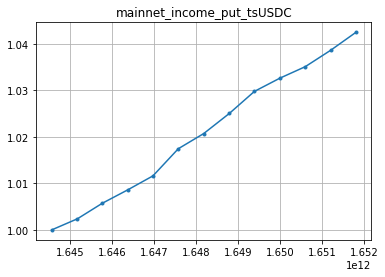

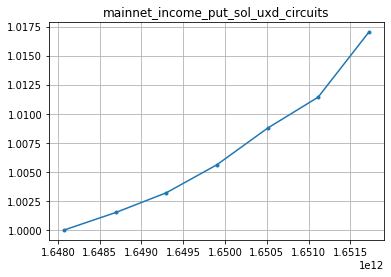

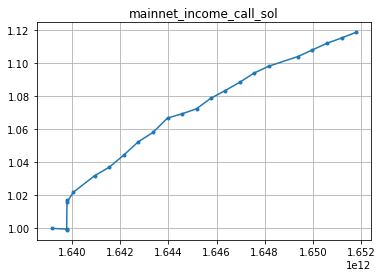

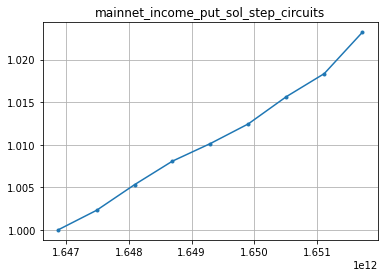

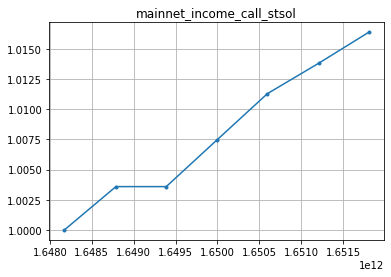

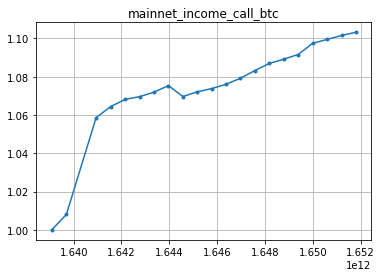

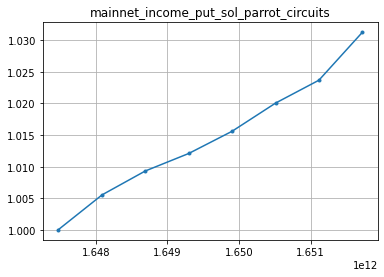

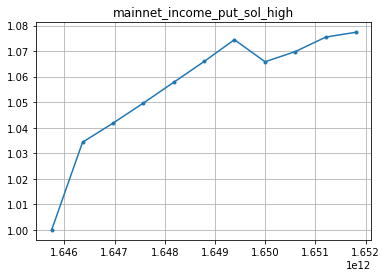

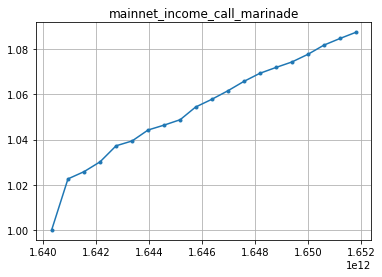

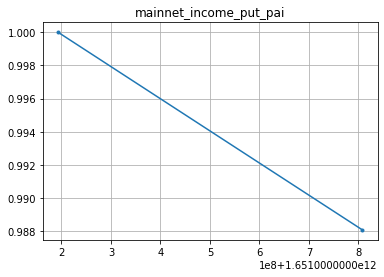

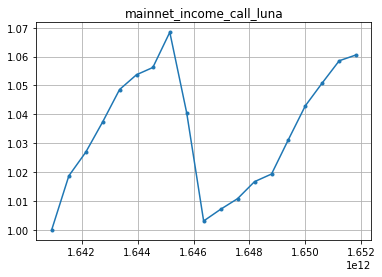

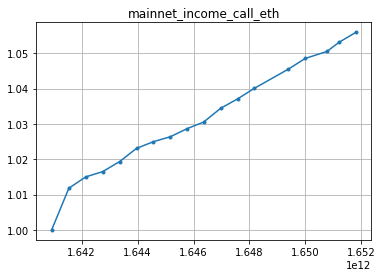

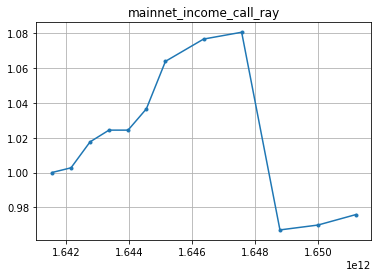

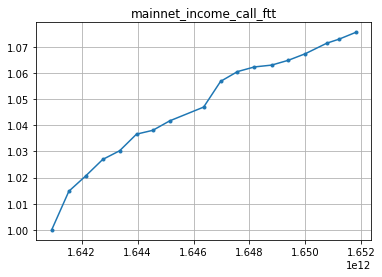

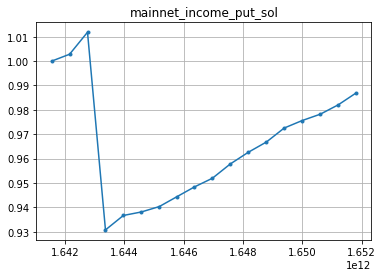

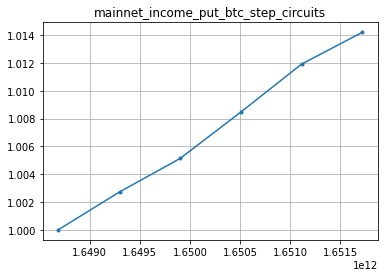

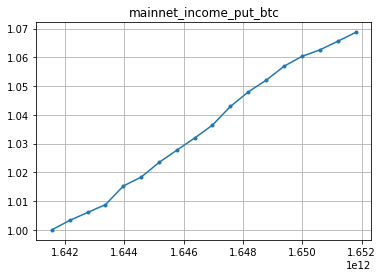

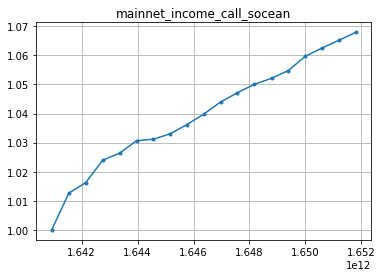

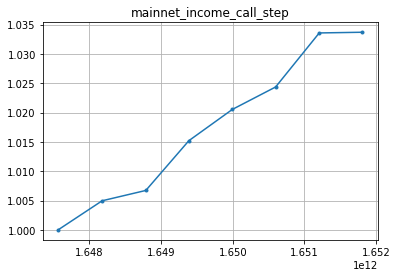

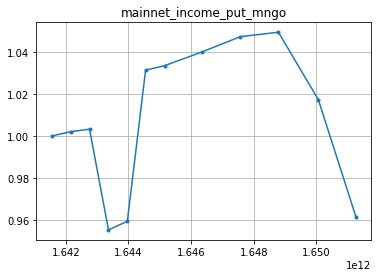

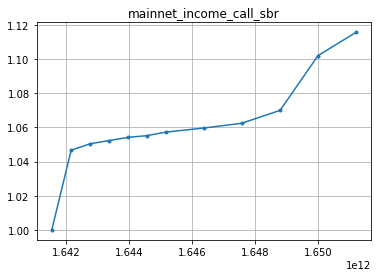

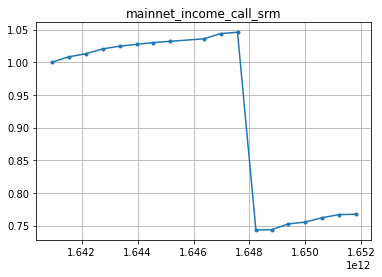

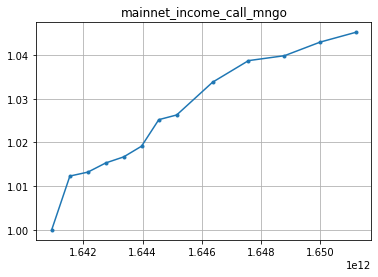

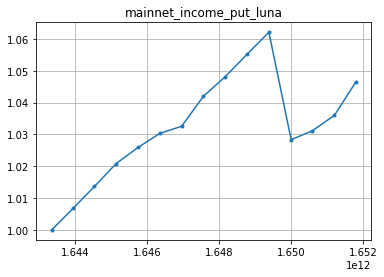

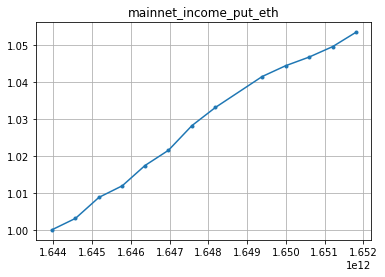

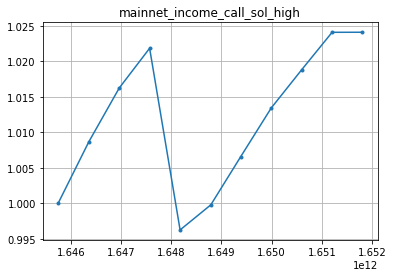

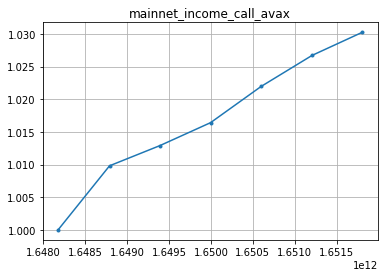

In [196]:
for globalId in end_round.globalId.unique():
    print(globalId)
    if globalId!=globalId:
        continue
    temp = end_round.query("globalId == @globalId").copy().sort_values("timestamp")
    output = temp[["timestamp_numba", "shareTokenPrice"]].values.tolist()
    output =  list(filter(lambda x: x, map(lambda x: [int(x[0]), x[1]] if x[1]==x[1] else None, output)))
    if output[0][1] < 0.999999 or output[0][1] > 1.0000001:
        output.insert(0, [output[0][0]-61*60*24*7*1000, 1.0])
    
    for override in OVERRIDES:
        if globalId == override["globalId"]:
            if override["operation"]=="insert":
                print(f"Inserted: {override['value']}")
                output.insert(override["index"], override["value"])
            elif override["operation"]=="replace":
                print(f"Replaced: {override['index']}")
                output[override["index"]] = override["value"]
                
    print(output)
    plt.figure()
    plt.plot([x[0] for x in output], [x[1] for x in output], marker='.')
    plt.title(globalId)
    plt.grid(True)

    with open(f'../derived_timeseries/{globalId}_sharePricesByGlobalId.json', 'w') as f:
        json.dump(output, f, separators=(",", ":"), indent=2)

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_31158/46826939.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


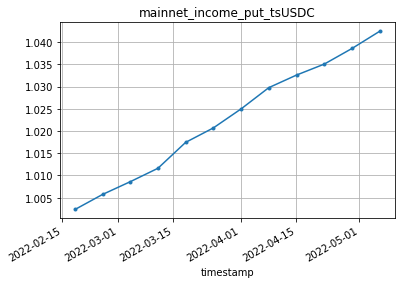

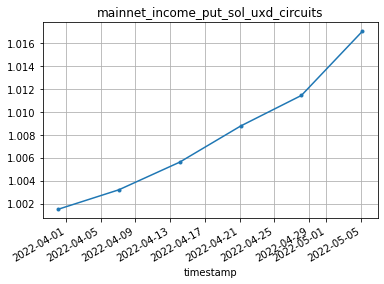

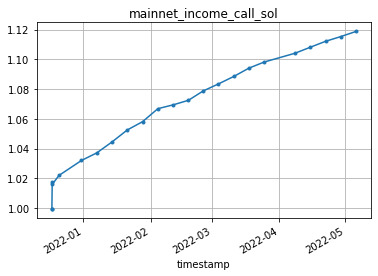

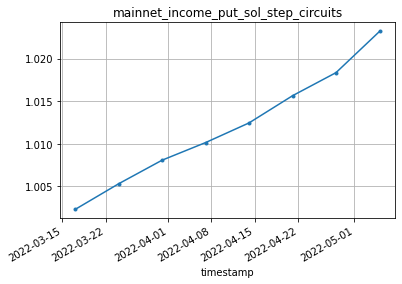

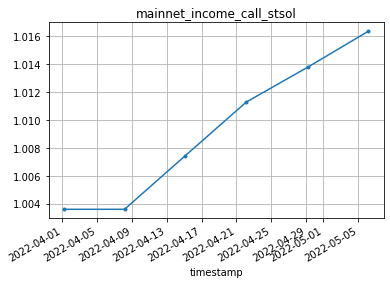

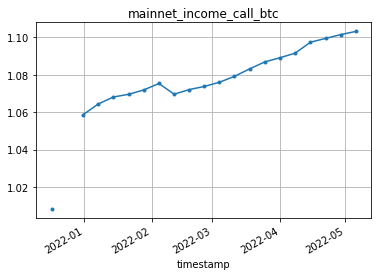

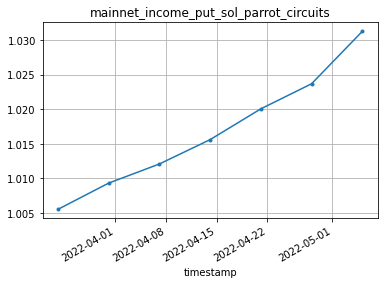

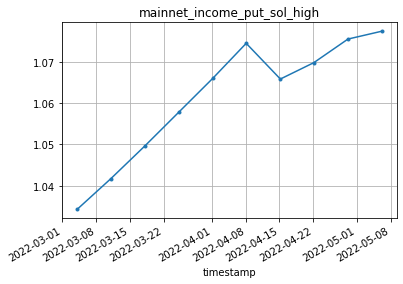

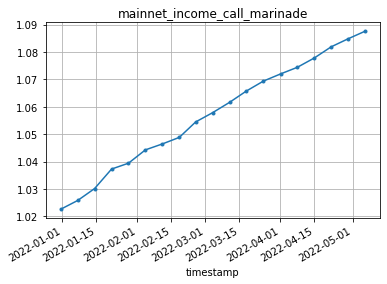

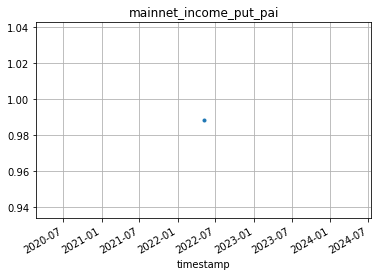

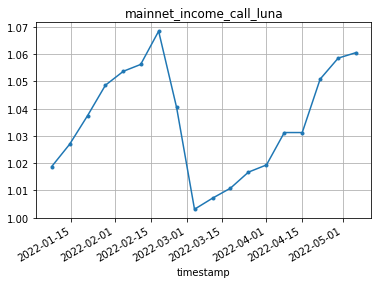

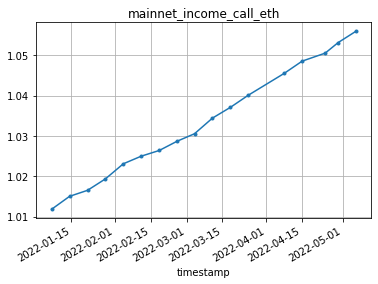

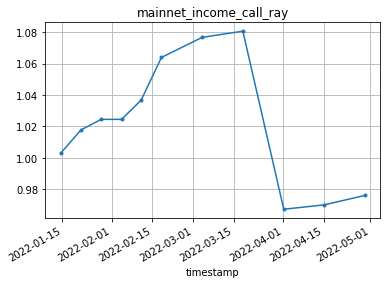

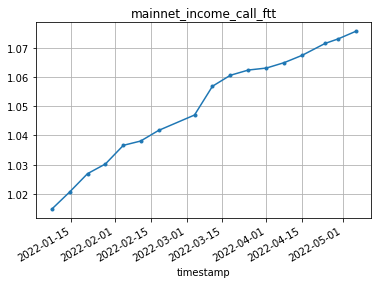

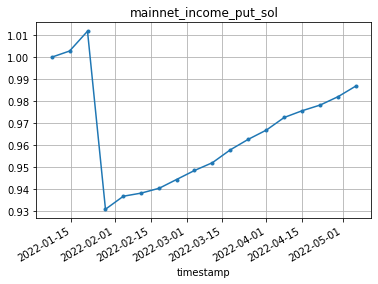

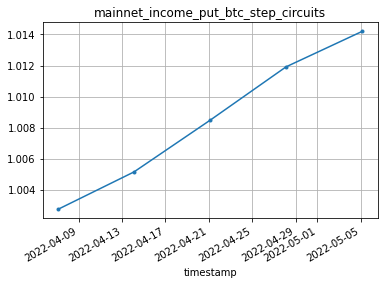

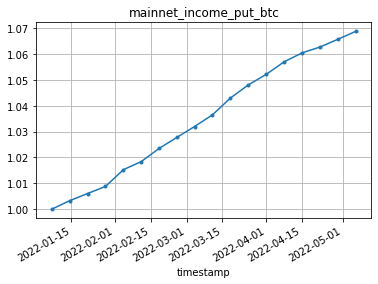

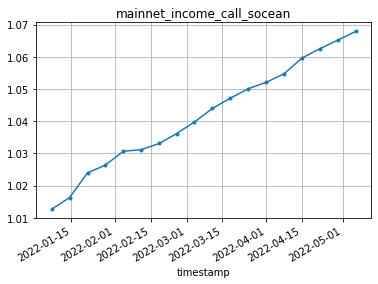

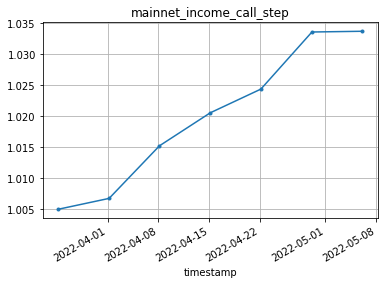

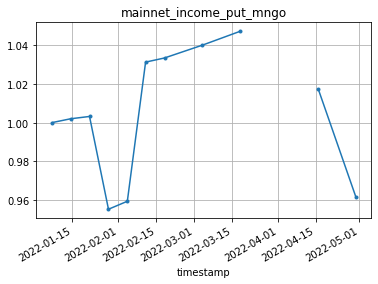

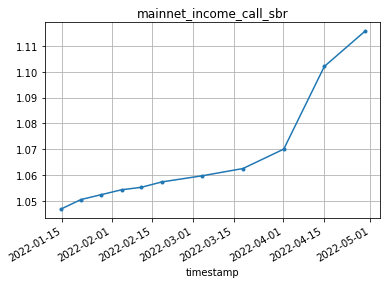

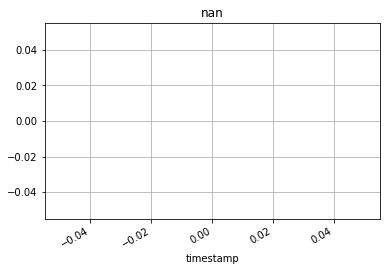

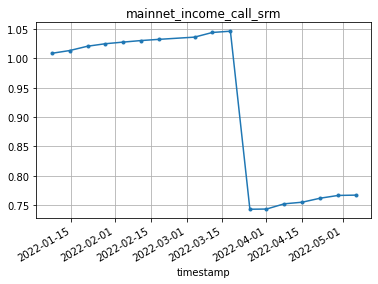

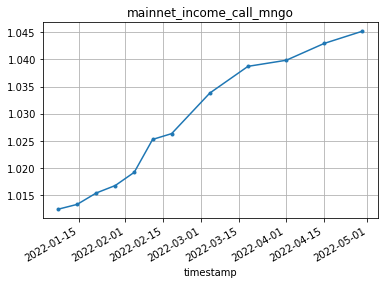

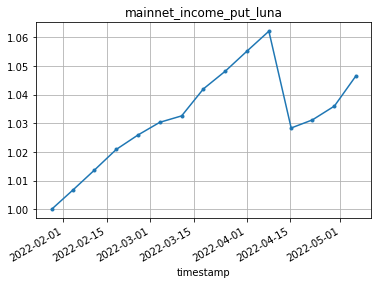

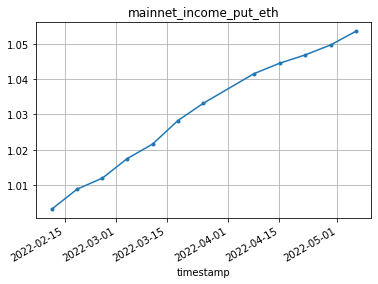

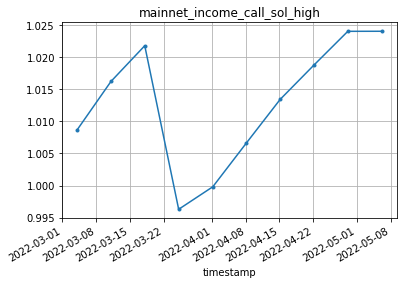

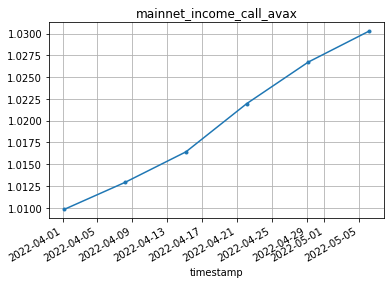

In [189]:
for globalId in end_round.globalId.unique():
    plt.figure()
    temp = end_round.query("globalId == @globalId").copy()
    temp["timestamp"] = pd.to_datetime(temp.timestamp)
    temp.set_index("timestamp").shareTokenPrice.plot(title=globalId, marker='.')
    plt.grid(True)